# EIMS Data
This script will read in the individual EIMS data files from the given directory and compile/prase the data for the model.

In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
Warning message:
"package 'R.matlab' was built under R version 3.4.3"R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: openxlsx
Warning message:
"package 'openxlsx' was built under R version 3.4.3"Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Loading required package: geosphere
Warning message:
"package 'geosphere' was built under R version 3.4.3"Loading required package: readxl
Loading required package: data.table
Warning message:
"package 'data.table' was built under R version 3.4.3"Loading required package: rworldmap
Warning message:
"package 'rworldmap' was built under R version 3.4.3"Loading required package: sp
Warning message:
"

# File Input

First we need to set the directory and file name criteria of the data to load. We also set the date-time format that the parser will be expecting.

In [50]:
input.dir = 'Raw Data/EIMS/'
output.dir = 'RStates/EIMS/'
dt.format = "%m/%d/%y %I:%M %p"
dt.format2 = "%m/%d/%y %H:%M"
dt.format3 = "%m/%d/%Y %H:%M"
dt.format4 = "%m/%d/%Y %I:%M %p"

## Generate list of files in the directory
file.list = list.files(input.dir)

## split file.list into usable lists
file.list.nu = file.list[grepl('not usable', file.list)] # not usable
file.list.2 = file.list[grepl('corr.txt', file.list)] # usable

## Print total number of files in each category
print(paste('Number of files in file.list:', length(file.list)))
print(paste('Number of files in file.list.2:', length(file.list.2)))
print(paste('Number of files in file.list.nu:', length(file.list.nu)))


[1] "Number of files in file.list: 177"
[1] "Number of files in file.list.2: 76"
[1] "Number of files in file.list.nu: 5"


In [51]:
file.list.2

[1] "2017-0601-1200 MID-valve corr.txt" "2017-0601-2031 MID-valve corr.txt"
 [3] "2017-0602-0000 MID-valve corr.txt" "2017-0602-1200 MID-valve corr.txt"
 [5] "2017-0602-1449 MID-valve corr.txt" "2017-0603-1200 MID-valve corr.txt"
 [7] "2017-0603-1347 MID-valve corr.txt" "2017-0603-1548 MID-valve corr.txt"
 [9] "2017-0603-2102 MID-valve corr.txt" "2017-0604-0000 MID-valve corr.txt"
[11] "2017-0604-0448 MID-valve corr.txt" "2017-0604-1200 MID-valve corr.txt"
[13] "2017-0605-0000 MID-valve corr.txt" "2017-0605-0440 MID-valve corr.txt"
[15] "2017-0605-0528 MID-valve corr.txt" "2017-0605-1200 MID-valve corr.txt"
[17] "2017-0606-0000 MID-valve corr.txt" "2017-0606-1200 MID-valve corr.txt"
[19] "2017-0606-1243 MID-valve corr.txt" "2017-0606-1259 MID-valve corr.txt"
[21] "2017-0607-0000 MID-valve corr.txt" "2017-0607-1200 MID-valve corr.txt"
[23] "2017-0608-0000 MID-valve corr.txt" "2017-0608-1200 MID-valve-corr.txt"
[25] "2017-0609-0000 MID-valve corr.txt" "2017-0609-1200 MID-valve corr.txt"
[27] "2017-0610-0000 MID-valve corr.txt" "2017-0610-1200 MID-valve corr.txt"
[29] "2017-0611-0000 MID-valve corr.txt" "2017-0611-1200 MID-valve corr.txt"
[31] "2017-0611-1326 MID-valve corr.txt" "2017-0611-1342 MID-valve corr.txt"
[33] "2017-0612-0000 MID-valve corr.txt" "2017-0612-1200 MID-valve corr.txt"
[35] "2017-0613-0000 MID-valve corr.txt" "2017-0613-1200 MID-valve corr.txt"
[37] "2017-0614-0000 MID-valve corr.txt" "2017-0614-1200 MID-valve corr.txt"
[39] "2017-0614-2001 MID-valve corr.txt" "2017-0615-0000 MID-valve corr.txt"
[41] "2017-0615-1200 MID-valve corr.txt" "2017-0616-1200 MID-valve corr.txt"
[43] "2017-0617-1200 MID-valve corr.txt" "2017-0618-0000 MID-valve corr.txt"
[45] "2017-0618-0620 MID-valve corr.txt" "2017-0618-0722 MID-valve corr.txt"
[47] "2017-0618-1200 MID-valve corr.txt" "2017-0619-0000 MID-valve corr.txt"
[49] "2017-0619-1200 MID-valve corr.txt" "2017-0620-0000 MID valve corr.txt"
[51] "2017-0620-1200 MID-vave corr.txt"  "2017-0621-0000 MID-valve corr.txt"
[53] "2017-0621-1200 MID-valve corr.txt" "2017-0622-0000 MID-valve corr.txt"
[55] "2017-0622-1200 MID-valve corr.txt" "2017-0623-0000 MID-valve corr.txt"
[57] "2017-0623-1200 MID-valve corr.txt" "2017-0624-0000 MID-valve corr.txt"
[59] "2017-0624-1200 MID-valve corr.txt" "2017-0625-0000 MID-valve corr.txt"
[61] "2017-0625-0647 MID-valve corr.txt" "2017-0625-1200 MID-valve corr.txt"
[63] "2017-0626-0000 MID-valve corr.txt" "2017-0626-1200 MID-valve corr.txt"
[65] "2017-0627-0000 MID-valve corr.txt" "2017-0627-1200 MID-valve corr.txt"
[67] "2017-0628-0000 MID-valve corr.txt" "2017-0628-1200 MID-valve corr.txt"
[69] "2017-0629-0000 MID-valve corr.txt" "2017-0629-1200 MID-valve corr.txt"
[71] "2017-0630-0000 MID-valve corr.txt" "2017-0630-1200 MID-valve corr.txt"
[73] "2017-0701-0000 MID-valve corr.txt" "2017-0701-1200 MID-valve corr.txt"
[75] "2017-0701-2058 MID-valve corr.txt" "2017-0702-0000 MID-valve corr.txt"

In [93]:
## Read in first data file and configure formatting around it
data = read.csv(paste0(input.dir, file.list.2[1]), sep='\t')
file.list.2[10]
data$time = strptime(data$time, format = dt.format2, tz='UTC')

data$time[1] # Sample value

[1] "2017-0604-0000 MID-valve corr.txt"

[1] "2021-06-02 12:00:00 UTC"

# Main Functions

These functions will do the heavy lifting for the EIMS preparation. The __avg.eims()__ generates the average of N minutes of samples while __filter.eims()__ goes QC type of work by removing high/low pressure samples and handles missing values.

In [58]:
## Average
avg.eims = function(x, N, flag = 1) {
    i = 1
    
    while (i < nrow(x)) {
        dt = as.numeric(difftime(x$time, x$time[i], unit='secs'))
        l = which(dt >= 0 & dt < N*60)
        
        ## Calculate the mean of the relevant columns, removing na's
        if (flag == 1) {
            x[i, 3:ncol(x)] = apply(x[l, 3:ncol(x)], 2, function(x) {mean(x, na.rm = TRUE)})
        } else {
            x[i, 3:ncol(x)] = apply(x[l, 3:ncol(x)], 2, function(x) {median(x, na.rm = TRUE)})
        }
        
        if (max(dt[l], na.rm = TRUE, 0) <= N / 2) {
            x$Flag[i] = 3
        }
    
        if (length(l) > 1) {
            l = l[l != i]
            if (length(l) > 1) {
                x = x[-l,]
            }
        }
        i = i + 1
    }
    x
}

## Prepare filter function
filter.eims = function(x) {
    x$Flag = 1
    
    ## Remove entries where flow not within 5% of 100
    x$Flag[x$flow > 105 | x$flow < 95] = 3 # Reject
    x$Flag[x$O2.Ar > 35 | x$O2.Ar < 16] = 3 # Reject
    
    ## Remove first 2 minute (safer to remove bad data than to keep it)
    l = which(as.numeric(difftime(x$time, x$time[1], unit='mins'))^2 < 2)
    x$Flag[l] = 3 # Reject
    
    ## Remove last 2 minute (safer to remove bad data than to keep it)
    l = which(as.numeric(difftime(x$time, x$time[nrow(x)], unit='mins'))^2 < 2)
    x$Flag[l] = 3 # Reject
    
    ## find all valve switches and remove all entries within a miute of it.
    l = which(diff(x$Valve) != 0)
    for (i in l) {
        dt = abs(as.numeric(difftime(x$time[i], x$time, unit='mins')))     
        x$Flag[which(dt <= 1)] = 3 # Reject
    }
    ## Remove NA O2Ar entries
    x$Flag[is.na(x$O2.Ar)] = 3 # Reject
    
    x$Flag[x$Valve == 2] = 2 # Calibration
    x$Flag[x$Valve == 3] = 3 # Rejject
    #x$Flag[is.na(x$Valve)] = 3 # Reject unknown valve
    
    x
}

## Check the filter and avg functions

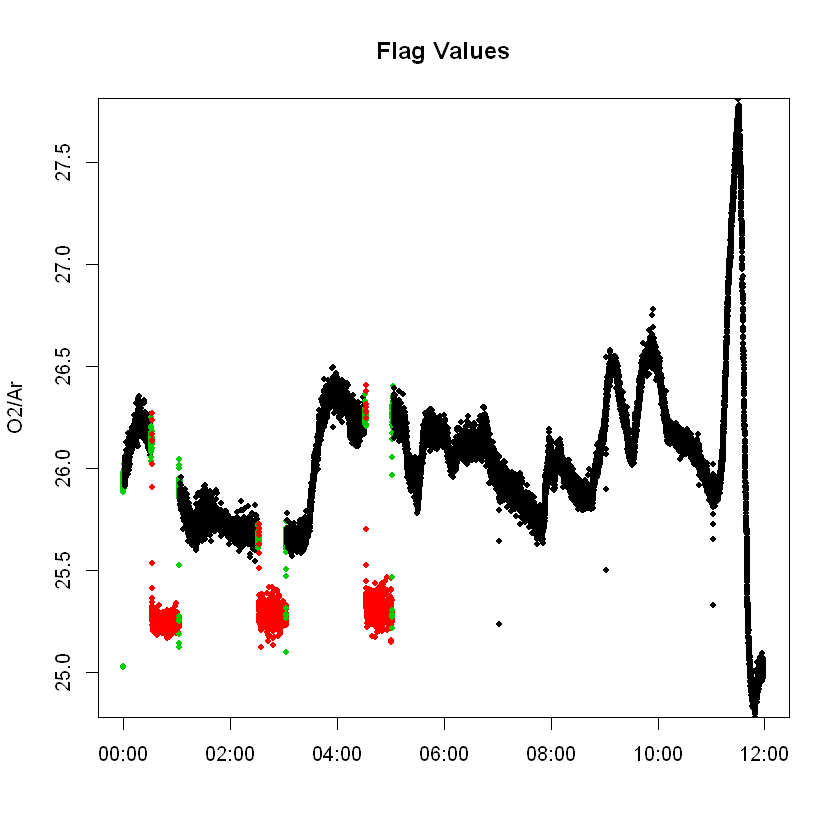

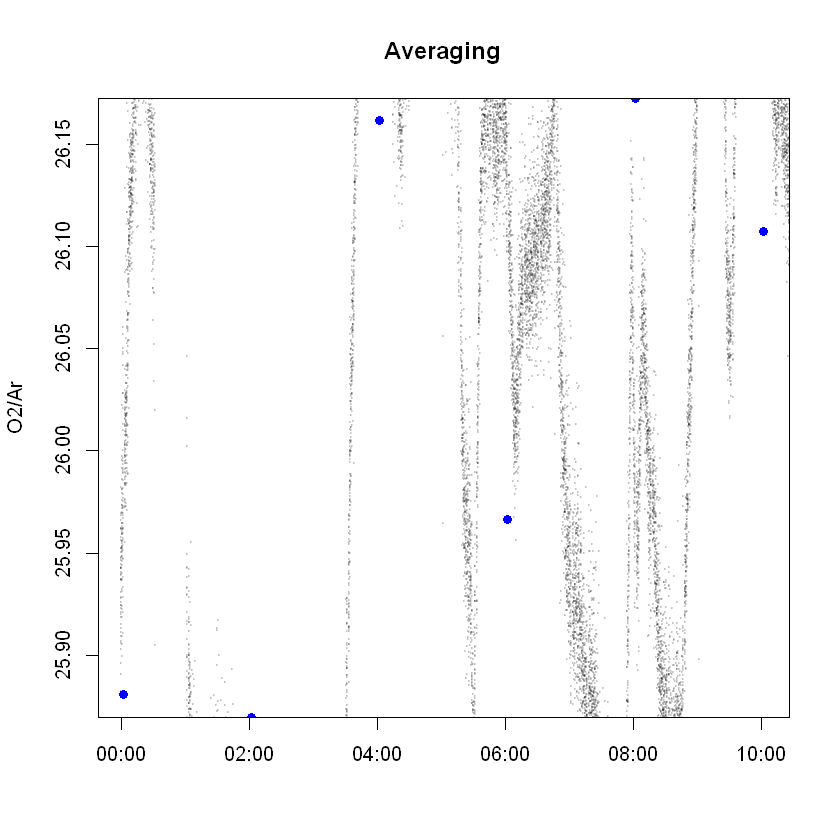

In [10]:
## Copy of data to run through filter (for tuning the filter parameters)
temp = data
temp = filter.eims(temp)
temp.avg = avg.eims(temp[temp$Flag == 1,], 120, flag = 1) # N = 2 min = 120 seconds
temp.cal = avg.eims(temp[temp$Flag == 2,], 120, flag = 2) # N = 2 min = 120 seconds

## Plot preliminary figures for visual check.
plot(temp$time, temp$O2.Ar, col = temp$Flag, pch=20, ylab='O2/Ar', xlab='', yaxs='i', main='Flag Values')

plot(temp.avg$time, temp.avg$O2.Ar, col = "blue", pch=16, ylab='O2/Ar', xlab='', yaxs='i', main='Averaging')
points(temp$time, temp$O2.Ar, col = "#00000020", pch=20, cex=0.3)
points(temp.cal$time, temp.cal$O2.Ar, col = "red", pch=20, cex=1.5)

In [94]:
read.eims = function(valve = 1, input.dir, file.list, N = 2, verbose = FALSE, template = data, make.img = FALSE) {
    ## Create template data structure to add new entries to:
    dat = template[1,] # valve = 1
    dat$Flag = 0
    
    for (i in file.list) {
        print('')
        print(paste0('Starting: ', i))
        
        #### load file and parse the time and filter the values
        data = read.csv(paste0(input.dir, i), sep='\t', stringsAsFactors = FALSE)
        
        times = data$time
        data$time = as.POSIXct(strptime(times, format = dt.format, tz='GMT'))
        
        if (is.na(data$time[1])) {
            data$time = as.POSIXct(strptime(times, format = dt.format2, tz='GMT'))
        }
        if (is.na(data$time[1])) {
            data$time = as.POSIXct(strptime(times, format = dt.format3, tz='GMT'))
        }
        if (is.na(data$time[1])) {
            data$time = as.POSIXct(strptime(times, format = dt.format4, tz='GMT'))
        }
        
        data$Flag = 0
        
        if (nrow(data) > 1) {
            ## Filter
            data = filter.eims(data)
        }
        
        if (make.img) {
            cols = c('black', 'orange', 'red')
    
            png(file = paste0('Output/EIMS/', i, '-valve-', valve, '.png'))
            if (nrow(data) > 1) {
                try({plot(data$time, data$O2.Ar, col=cols[data$Flag],
                          pch=20, ylab='O2/Ar', xlab='', main=i, cex=0.2,
                          ylim=c(15,30))})
            } else {
                plot(0, 0)
            }
            
        }
        
        ## Verbose
        if (verbose) { print(paste("Loaded file:", i)) }
        
        #### determine valve  
        l = which(data$Valve == valve)
        
        if (length(l) > 1) {
            temp = avg.eims(data[l,], N, valve)
            if (make.img) {
                if (valve == 2) {
                    points(temp$time, temp$O2.Ar, pch=7)
                    lines(temp$time, temp$O2.Ar, col='#00000080')
                }
            dev.off()
            }
        } else {
          if(make.img) {
              dev.off()
          }   
        }
             
        if (length(names(temp)) == length(names(dat))) {
            ## Do the column names match?
            names(temp) = names(dat) # Force colname match (dangerous), but will check that lengths are the same
            dat = rbind(dat, temp)
            
            if (verbose) { print(paste('  Added', nrow(temp),'to valve ', valve, '.')) }
            
        }
        else {print('error'); print(i)}
    }


    ## Remove the first row used to initiate the table
    dat = dat[-1,]
    dat = dat[,-c(13, 14, 15, 23, 24, 25)]
    
    dat
}

## Run the parser
This will initialize the parser for valve = 1 (sampling) and then valve = 2 (calibration). Included in this is the ___filter.eims()___ and ___take.avg()___ functions.

__NB This will take a while...__

In [96]:
data.v1 = read.eims(1, input.dir, file.list.2, N = 2, verbose = TRUE, template = data, make.img = TRUE)
#data.v1 = read.eims(1, input.dir, file.list.2, N = 30, verbose = FALSE, template = data, make.img = FALSE)

[1] ""
[1] "Starting: 2017-0601-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0601-1200 MID-valve corr.txt"
[1] "  Added 42 to valve  1 ."
[1] ""
[1] "Starting: 2017-0601-2031 MID-valve corr.txt"
[1] "Loaded file: 2017-0601-2031 MID-valve corr.txt"
[1] "  Added 76 to valve  1 ."
[1] ""
[1] "Starting: 2017-0602-0000 MID-valve corr.txt"
[1] "Loaded file: 2017-0602-0000 MID-valve corr.txt"
[1] "  Added 320 to valve  1 ."
[1] ""
[1] "Starting: 2017-0602-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0602-1200 MID-valve corr.txt"
[1] "  Added 82 to valve  1 ."
[1] ""
[1] "Starting: 2017-0602-1449 MID-valve corr.txt"
[1] "Loaded file: 2017-0602-1449 MID-valve corr.txt"
[1] "  Added 251 to valve  1 ."
[1] ""
[1] "Starting: 2017-0603-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0603-1200 MID-valve corr.txt"
[1] "  Added 49 to valve  1 ."
[1] ""
[1] "Starting: 2017-0603-1347 MID-valve corr.txt"
[1] "Loaded file: 2017-0603-1347 MID-valve corr.txt"
[1] "  Added 58 to valve  1 ."
[1] ""
[1] 

[1] "Loaded file: 2017-0624-1200 MID-valve corr.txt"
[1] "  Added 337 to valve  1 ."
[1] ""
[1] "Starting: 2017-0625-0000 MID-valve corr.txt"
[1] "Loaded file: 2017-0625-0000 MID-valve corr.txt"
[1] "  Added 182 to valve  1 ."
[1] ""
[1] "Starting: 2017-0625-0647 MID-valve corr.txt"
[1] "Loaded file: 2017-0625-0647 MID-valve corr.txt"
[1] "  Added 56 to valve  1 ."
[1] ""
[1] "Starting: 2017-0625-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0625-1200 MID-valve corr.txt"
[1] "  Added 335 to valve  1 ."
[1] ""
[1] "Starting: 2017-0626-0000 MID-valve corr.txt"
[1] "Loaded file: 2017-0626-0000 MID-valve corr.txt"
[1] "  Added 284 to valve  1 ."
[1] ""
[1] "Starting: 2017-0626-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0626-1200 MID-valve corr.txt"
[1] "  Added 149 to valve  1 ."
[1] ""
[1] "Starting: 2017-0627-0000 MID-valve corr.txt"
[1] "Loaded file: 2017-0627-0000 MID-valve corr.txt"
[1] "  Added 326 to valve  1 ."
[1] ""
[1] "Starting: 2017-0627-1200 MID-valve corr.txt"
[1] "Lo

In [98]:
data.v2 = read.eims(2, input.dir, file.list.2, N = 120, verbose = TRUE, template = data, make.img = TRUE)

[1] ""
[1] "Starting: 2017-0601-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0601-1200 MID-valve corr.txt"
[1] "  Added 1 to valve  2 ."
[1] ""
[1] "Starting: 2017-0601-2031 MID-valve corr.txt"
[1] "Loaded file: 2017-0601-2031 MID-valve corr.txt"
[1] "  Added 2 to valve  2 ."
[1] ""
[1] "Starting: 2017-0602-0000 MID-valve corr.txt"
[1] "Loaded file: 2017-0602-0000 MID-valve corr.txt"
[1] "  Added 3 to valve  2 ."
[1] ""
[1] "Starting: 2017-0602-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0602-1200 MID-valve corr.txt"
[1] "  Added 3 to valve  2 ."
[1] ""
[1] "Starting: 2017-0602-1449 MID-valve corr.txt"
[1] "Loaded file: 2017-0602-1449 MID-valve corr.txt"
[1] "  Added 2 to valve  2 ."
[1] ""
[1] "Starting: 2017-0603-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0603-1200 MID-valve corr.txt"
[1] "  Added 2 to valve  2 ."
[1] ""
[1] "Starting: 2017-0603-1347 MID-valve corr.txt"
[1] "Loaded file: 2017-0603-1347 MID-valve corr.txt"
[1] "  Added 2 to valve  2 ."
[1] ""
[1] "Starting

[1] "Loaded file: 2017-0625-0000 MID-valve corr.txt"
[1] "  Added 1 to valve  2 ."
[1] ""
[1] "Starting: 2017-0625-0647 MID-valve corr.txt"
[1] "Loaded file: 2017-0625-0647 MID-valve corr.txt"
[1] "  Added 1 to valve  2 ."
[1] ""
[1] "Starting: 2017-0625-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0625-1200 MID-valve corr.txt"
[1] "  Added 3 to valve  2 ."
[1] ""
[1] "Starting: 2017-0626-0000 MID-valve corr.txt"
[1] "Loaded file: 2017-0626-0000 MID-valve corr.txt"
[1] "  Added 3 to valve  2 ."
[1] ""
[1] "Starting: 2017-0626-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0626-1200 MID-valve corr.txt"
[1] "  Added 1 to valve  2 ."
[1] ""
[1] "Starting: 2017-0627-0000 MID-valve corr.txt"
[1] "Loaded file: 2017-0627-0000 MID-valve corr.txt"
[1] "  Added 3 to valve  2 ."
[1] ""
[1] "Starting: 2017-0627-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0627-1200 MID-valve corr.txt"
[1] "  Added 3 to valve  2 ."
[1] ""
[1] "Starting: 2017-0628-0000 MID-valve corr.txt"
[1] "Loaded file: 20

In [99]:
data.v3 = read.eims(3, input.dir, file.list.2, N = 2, verbose = TRUE, template = data, make.img = TRUE)

[1] ""
[1] "Starting: 2017-0601-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0601-1200 MID-valve corr.txt"
[1] "  Added 33544 to valve  3 ."
[1] ""
[1] "Starting: 2017-0601-2031 MID-valve corr.txt"
[1] "Loaded file: 2017-0601-2031 MID-valve corr.txt"
[1] "  Added 33544 to valve  3 ."
[1] ""
[1] "Starting: 2017-0602-0000 MID-valve corr.txt"
[1] "Loaded file: 2017-0602-0000 MID-valve corr.txt"
[1] "  Added 33544 to valve  3 ."
[1] ""
[1] "Starting: 2017-0602-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0602-1200 MID-valve corr.txt"
[1] "  Added 33544 to valve  3 ."
[1] ""
[1] "Starting: 2017-0602-1449 MID-valve corr.txt"
[1] "Loaded file: 2017-0602-1449 MID-valve corr.txt"
[1] "  Added 33544 to valve  3 ."
[1] ""
[1] "Starting: 2017-0603-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0603-1200 MID-valve corr.txt"
[1] "  Added 33544 to valve  3 ."
[1] ""
[1] "Starting: 2017-0603-1347 MID-valve corr.txt"
[1] "Loaded file: 2017-0603-1347 MID-valve corr.txt"
[1] "  Added 33544 to valv

[1] "Loaded file: 2017-0624-1200 MID-valve corr.txt"
[1] "  Added 27 to valve  3 ."
[1] ""
[1] "Starting: 2017-0625-0000 MID-valve corr.txt"
[1] "Loaded file: 2017-0625-0000 MID-valve corr.txt"
[1] "  Added 27 to valve  3 ."
[1] ""
[1] "Starting: 2017-0625-0647 MID-valve corr.txt"
[1] "Loaded file: 2017-0625-0647 MID-valve corr.txt"
[1] "  Added 78 to valve  3 ."
[1] ""
[1] "Starting: 2017-0625-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0625-1200 MID-valve corr.txt"
[1] "  Added 78 to valve  3 ."
[1] ""
[1] "Starting: 2017-0626-0000 MID-valve corr.txt"
[1] "Loaded file: 2017-0626-0000 MID-valve corr.txt"
[1] "  Added 43 to valve  3 ."
[1] ""
[1] "Starting: 2017-0626-1200 MID-valve corr.txt"
[1] "Loaded file: 2017-0626-1200 MID-valve corr.txt"
[1] "  Added 43 to valve  3 ."
[1] ""
[1] "Starting: 2017-0627-0000 MID-valve corr.txt"
[1] "Loaded file: 2017-0627-0000 MID-valve corr.txt"
[1] "  Added 43 to valve  3 ."
[1] ""
[1] "Starting: 2017-0627-1200 MID-valve corr.txt"
[1] "Loaded f

In [100]:
## Also, correct the time since the year is not actually 2021...
data.v1$time = data.v1$time - 4 * 365.25 * 86400 - 86400
data.v2$time = data.v2$time - 4 * 365.25 * 86400 - 86400
data.v3$time = data.v3$time - 4 * 365.25 * 86400 - 86400

## Remove NA O2:Ar values
data.v1 = data.v1[which(!is.na(data.v1$O2.Ar)),]
data.v2 = data.v2[which(!is.na(data.v2$O2.Ar)),]
data.v3 = data.v3[which(!is.na(data.v3$O2.Ar)),]

## Number of entries, do they seem right?
print(paste0('Valve 1 has ', nrow(data.v1), ' entries with ', length(which(data.v1$Flag == 3)), ' flagged values.'))
print(paste0('Valve 2 has ', nrow(data.v2), ' entries with ', length(which(data.v2$Flag == 3)), ' flagged values.'))
print(paste0('Valve 3 has ', nrow(data.v3), ' entries with ', length(which(data.v3$Flag == 3)), ' flagged values.'))

eims = list(sample = data.v1, cal = data.v2, error = data.v3)

[1] "Valve 1 has 17215 entries with 511 flagged values."
[1] "Valve 2 has 176 entries with 1 flagged values."
[1] "Valve 3 has 270382 entries with 6118 flagged values."


In [107]:
eims$sample = eims$sample[which(eims$sample$time > as.POSIXct('2016-01-01 00:00', tz = 'UTC')), ]
eims$cal = eims$cal[which(eims$cal$time > as.POSIXct('2016-01-01 00:00', tz = 'UTC')), ]
eims$error = eims$error[which(eims$error$time > as.POSIXct('2016-01-01 00:00', tz = 'UTC')), ]

## Review results

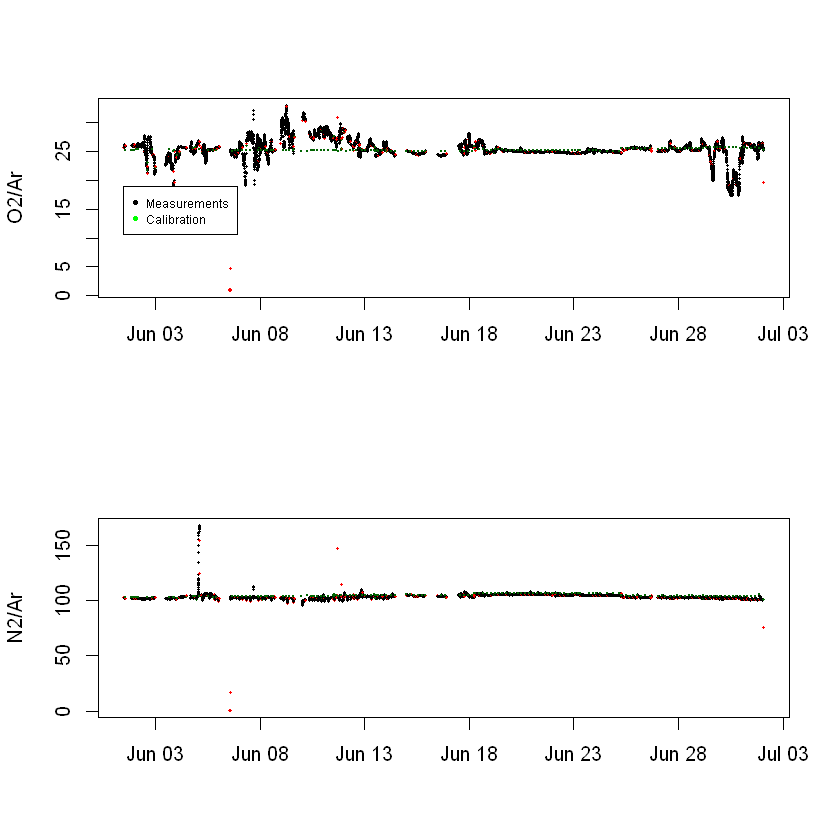

png 
  3

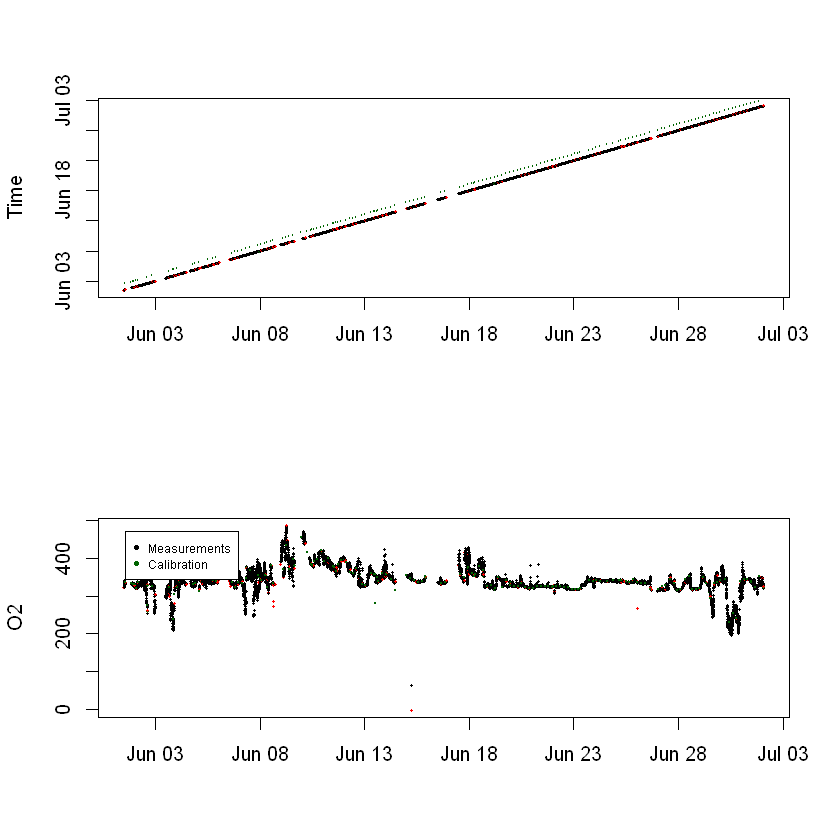

In [110]:
#pdf('./Output/Generate EIMS - Review 1.pdf')

par(mfrow=c(2,1))
cols = c('black', 'dark green', 'red')

plot(eims$sample$time, eims$sample$O2.Ar, pch=16, cex=0.3, ylab='O2/Ar', xlab='', col=cols[eims$sample$Flag])
points(eims$cal$time, eims$cal$O2.Ar, pch=16, cex=0.2, col=cols[eims$cal$Flag])

legend(data.v1$time[1], 19, c('Measurements', 'Calibration'), col=c('black', 'green'), pch=16, cex=0.6)

plot(eims$sample$time, eims$sample$N2.Ar, pch=16, cex=0.3, ylab='N2/Ar', xlab='', col=cols[eims$sample$Flag])
points(eims$cal$time, eims$cal$N2.Ar, pch=16, cex=0.2, col=cols[eims$cal$Flag])

plot(eims$sample$time, eims$sample$time, pch=16, cex=0.3, ylab='Time', xlab='', col=cols[eims$sample$Flag])
points(eims$cal$time, eims$cal$time+86400, cex=0.2, col=cols[eims$cal$Flag])

plot(eims$sample$time, eims$sample$O2..uM., pch=16, cex=0.3, ylab='O2', xlab='', col=cols[eims$sample$Flag])
points(eims$cal$time, eims$cal$O2..uM., pch=16, cex=0.2, col=cols[eims$cal$Flag])

legend(eims$cal$time[1], 470, c('Measurements', 'Calibration'), col=c('black', 'dark green'), pch=16, cex=0.6)

dev.off()

png 
  3

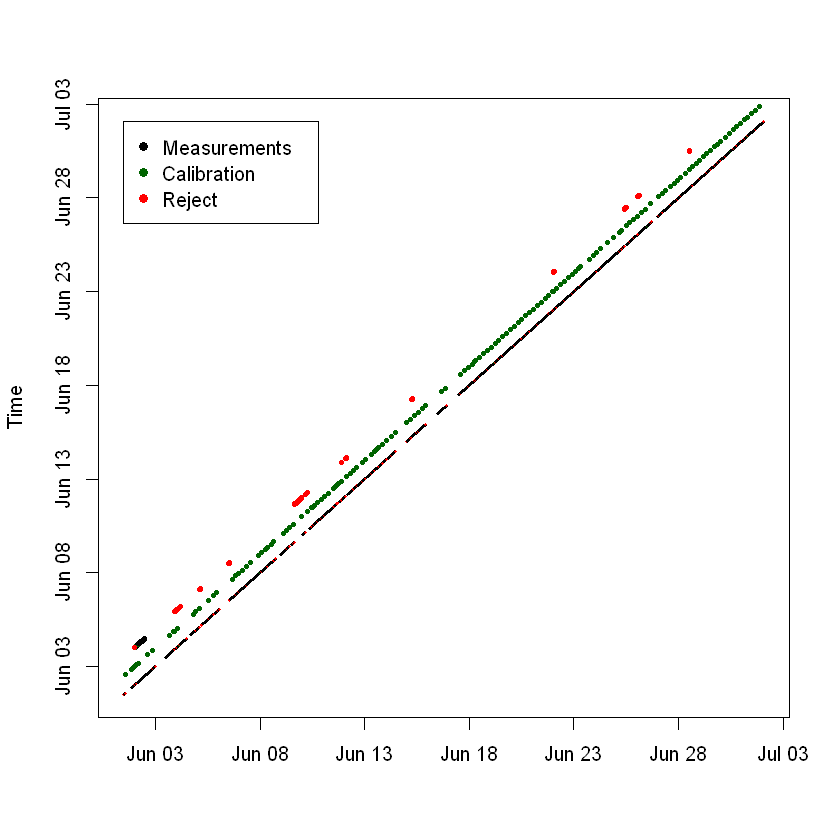

In [113]:
#pdf('./Output/Generate EIMS - Review 2.pdf')

plot(eims$sample$time, eims$sample$time, pch=16, cex=0.3, ylab='Time', xlab='', col = cols[eims$sample$Flag])
points(eims$cal$time, eims$cal$time+86400, pch=16, cex=0.5, col = cols[eims$cal$Flag])
points(eims$error$time, eims$error$time+86400*2, pch=16, cex=0.5, col = cols[eims$error$Flag])
legend(eims$sample$time[1], eims$sample$time[nrow(eims$sample)], c('Measurements', 'Calibration', 'Reject'),
       col=cols, pch=16)

dev.off()

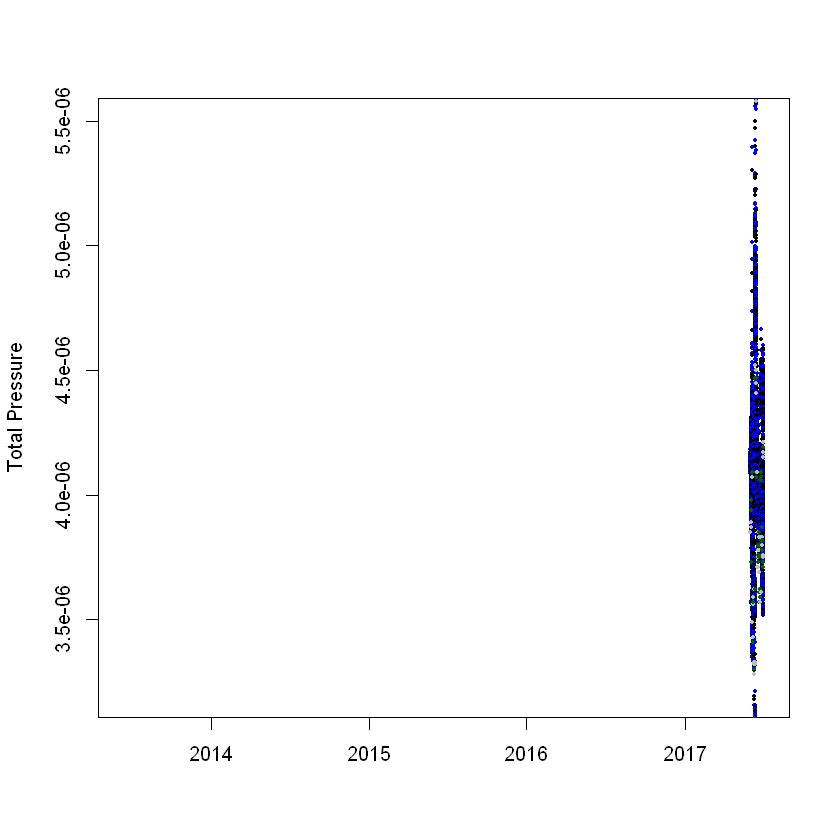

In [114]:
plot(data.v1$time, data.v1$TP, col='white', ylim=c(3.2e-6, 5.5e-6), ylab='Total Pressure', xlab='')

col = c('Black', 'blue', 'grey', 'dark green')

for (i in 1:length(unique(eims$sample[,1]))) {
    l = which(eims$sample[,1] == unique(data.v1[,1])[i])
    points(eims$sample$time[l], eims$sample$TP[l], col=col[i %% 2 + 1], pch=20, cex=0.6)
}

for (i in 1:length(unique(eims$cal[,1]))) {
    l = which(eims$cal[,1] == unique(eims$cal[,1])[i])
    points(eims$cal$time[l], eims$cal$TP[l], col=col[i %% 2 + 3], pch=20, cex=0.6)
}


png 
  3

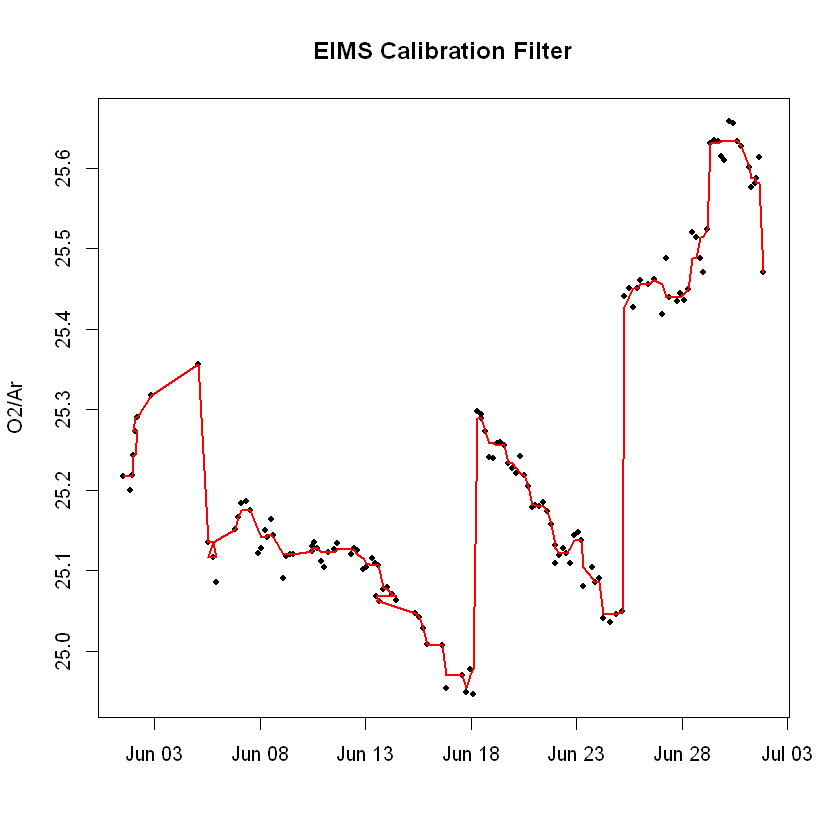

In [122]:
#pdf('Output/Generate EIMS - Calibration Filter - post.pdf')

plot(eims$cal$time, eims$cal$O2.Ar, pch=20, ylab='O2/Ar', xlab='', main='EIMS Calibration Filter')
lines(eims$cal$time, runmed(eims$cal$O2.Ar, 5), col='red', lwd=2)

delta = abs(runmed(eims$cal$O2.Ar, 5) - eims$cal$O2.Ar)
l = which(delta > 0.05)
points(eims$cal$time[l], eims$cal$O2.Ar[l], pch=16, col='red')

lines(eims$cal$time[-l], runmed(eims$cal$O2.Ar[-l], 5))

dev.off()

In [119]:
## Apply Calibration Filter
eims$cal = eims$cal[-l,]

---
# Save

In [123]:
## Save the data
save(eims, file='./RStates/EIMS.2min.120min.rdata')
#save(eims, file='./RStates/EIMS.30min.120min.rdata')

## Optional
#write.xlsx(data.v1, './Input Data/EIMS-Valve1.2min.xlsx')
#write.xlsx(data.v2, './Input Data/EIMS-Valve2.60min.xlsx')

---
# Review

In [ ]:
load('./RStates/EIMS.2min.120min.rdata')

In [124]:
par(mfrow=c(3,1))

pdf('Output/Generate EIMS - 24H Plots.pdf')

dt = floor(as.numeric(difftime(eims$sample$time, min(eims$sample$time, na.rm = TRUE), units='days')))

for (i in 1:floor(max(dt, na.rm = TRUE))) {
    k = which(dt ==i)
    if(length(k) < 1) {
        k = 1
    }
    plot(eims$sample$time[k], eims$sample$O2.Ar[k], pch=20, main=paste('Day', i, '-', eims$sample$time[k[1]]), xlab='',
         ylab='O2/Ar', ylim=c(18,33), cex=0.5, yaxs='i')
    points(eims$cal$time, eims$cal$O2.Ar, pch=4, col='red')
}

dev.off()

png 
  2